In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from google.colab import drive

# Menghubungkan ke Google Drive
drive.mount('/content/drive')

# Definisi Path Utama
BASE_PATH = '/content/drive/MyDrive/Project_PCD_Banjir'
IMG_PATH = os.path.join(BASE_PATH, 'image')
MASK_PATH = os.path.join(BASE_PATH, 'mask')

# Verifikasi akses folder
if os.path.exists(IMG_PATH) and os.path.exists(MASK_PATH):
    print("Sistem Konfirmasi: Folder image dan mask ditemukan.")
    print(f"Jumlah gambar: {len(os.listdir(IMG_PATH))}")
    print(f"Jumlah mask: {len(os.listdir(MASK_PATH))}")
else:
    print("Sistem Peringatan: Folder belum sesuai. Pastikan nama folder adalah 'image' dan 'mask' di dalam Project_PCD_Banjir.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sistem Konfirmasi: Folder image dan mask ditemukan.
Jumlah gambar: 126
Jumlah mask: 153


Informasi Dataset:
Total baris di metadata.csv: 290


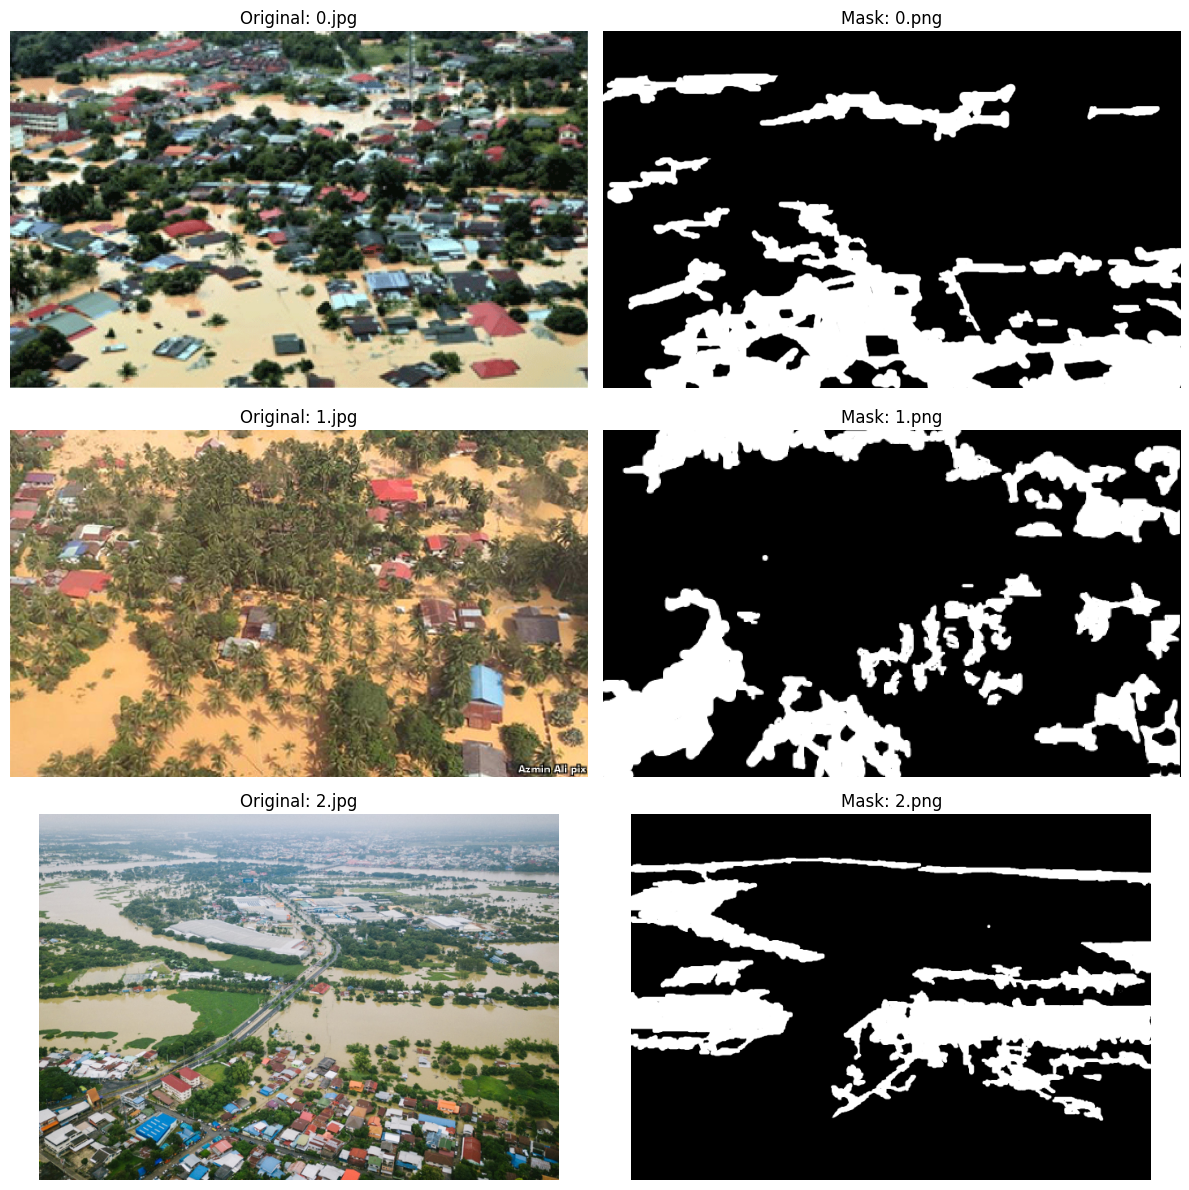

In [ ]:
# Membaca metadata
csv_path = os.path.join(BASE_PATH, 'metadata.csv')
df = pd.read_csv(csv_path)

print("Informasi Dataset:")
print(f"Total baris di metadata.csv: {len(df)}")

# Fungsi menampilkan sampel untuk memastikan koordinasi file benar
def verifikasi_visual(data_frame, jumlah=3):
    plt.figure(figsize=(12, jumlah * 4))
    tersedia = 0
    idx = 0

    while tersedia < jumlah and idx < len(data_frame):
        img_file = str(data_frame.iloc[idx]['Image'])
        mask_file = str(data_frame.iloc[idx]['Mask'])

        p_img = os.path.join(IMG_PATH, img_file)
        p_msk = os.path.join(MASK_PATH, mask_file)

        if os.path.exists(p_img) and os.path.exists(p_msk):
            img = cv2.imread(p_img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(p_msk, cv2.IMREAD_GRAYSCALE)

            plt.subplot(jumlah, 2, tersedia * 2 + 1)
            plt.imshow(img)
            plt.title(f"Original: {img_file}")
            plt.axis('off')

            plt.subplot(jumlah, 2, tersedia * 2 + 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f"Mask: {mask_file}")
            plt.axis('off')

            tersedia += 1
        idx += 1

    plt.tight_layout()
    plt.show()

verifikasi_visual(df)

In [ ]:
# Fungsi untuk pembagian data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

class FloodDataset(Sequence):
    def __init__(self, data_frame, img_path, mask_path, img_size=(256, 256), batch_size=8, **kwargs):
        super().__init__(**kwargs)
        self.df = data_frame
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_size = img_size
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size : (idx + 1) * self.batch_size]
        images, masks = [], []

        for _, row in batch_df.iterrows():
            p_img = os.path.join(self.img_path, str(row['Image']))
            p_msk = os.path.join(self.mask_path, str(row['Mask']))

            if os.path.exists(p_img) and os.path.exists(p_msk):
                img = cv2.imread(p_img)
                mask = cv2.imread(p_msk, cv2.IMREAD_GRAYSCALE)

                if img is not None and mask is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, self.img_size)
                    mask = cv2.resize(mask, self.img_size)

                    images.append(img / 255.0)
                    masks.append(np.expand_dims(mask / 255.0, axis=-1))

        # Penanganan jika batch kosong: ambil data pertama sebagai placeholder agar tidak error
        if len(images) == 0:
            dummy_img = np.zeros((*self.img_size, 3))
            dummy_msk = np.zeros((*self.img_size, 1))
            return np.array([dummy_img], dtype='float32'), np.array([dummy_msk], dtype='float32')

        return np.array(images, dtype='float32'), np.array(masks, dtype='float32')

# Inisialisasi ulang generator
train_gen = FloodDataset(train_df, IMG_PATH, MASK_PATH)
val_gen = FloodDataset(val_df, IMG_PATH, MASK_PATH)

print("Generator telah diperbarui. Silakan lanjut jalankan Sel 5 (Training).")

Generator telah diperbarui. Silakan lanjut jalankan Sel 5 (Training).


In [ ]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet_standard(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder (Downsampling)
    s1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(s1)

    s2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(s2)

    # Bridge / Bottleneck
    b1 = conv_block(p2, 256)

    # Decoder (Upsampling)
    d1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(b1)
    d1 = layers.concatenate([d1, s2]) # Skip connection
    d1 = conv_block(d1, 128)

    d2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(d1)
    d2 = layers.concatenate([d2, s1]) # Skip connection
    d2 = conv_block(d2, 64)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d2)

    return models.Model(inputs, outputs, name="UNet_Standard")

model_std = build_unet_standard()
model_std.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_std.summary()

Model: "UNet_Standard"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_14[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_196[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 128, 128,  │          0 │ conv2d_197[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_28… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_199 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_198[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 64, 64,    │          0 │ conv2d_199[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_200 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_29… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_201 (Conv2D) │ (None, 64, 64,    │    590,080 │ conv2d_200[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_28 │ (None, 128, 128,  │    131,200 │ conv2d_201[0][0]  │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_199[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_202 (Conv2D) │ (None, 128, 128,  │    295,040 │ concatenate_28[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_202[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_29 │ (None, 256, 256,  │     32,832 │ conv2d_203[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_29      │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_197[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 256, 256,  │     73,792 │ concatenate_29[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_204[0][0]

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Menyimpan model terbaik
checkpoint_path = os.path.join(BASE_PATH, 'best_model_standard.h5')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

# Menghentikan pelatihan jika tidak ada perkembangan
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

print("Memulai pelatihan model U-Net Standar...")

history_std = model_std.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

Memulai pelatihan model U-Net Standar...
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.5822 - loss: 0.7035
Epoch 1: val_loss improved from inf to 0.59864, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_standard.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 850ms/step - accuracy: 0.5825 - loss: 0.7029 - val_accuracy: 0.6331 - val_loss: 0.5986
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6600 - loss: 0.5572
Epoch 2: val_loss improved from 0.59864 to 0.46644, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_standard.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.6613 - loss: 0.5567 - val_accuracy: 0.8014 - val_loss: 0.4664
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6983 - loss: 0.5572
Epoch 3: val_loss improved from 0.46644 to 0.42254, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_standard.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.6988 - loss: 0.5564 - val_accuracy: 0.7996 - val_loss: 0.4225
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7769 - loss: 0.4558
Epoch 4: val_loss improved from 0.42254 to 0.38415, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_standard.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7767 - loss: 0.4560 - val_accuracy: 0.8168 - val_loss: 0.3842
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7859 - loss: 0.4381
Epoch 5: val_loss did not improve from 0.38415
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.7858 - loss: 0.4389 - val_accuracy: 0.8145 - val_loss: 0.4476
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7244 - loss: 0.4861
Epoch 6: val_loss did not improve from 0.38415
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.7252 - loss: 0.4858 - val_accuracy: 0.8174 - val_loss: 0.4025
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7905 - loss: 0.4274
Epoch 7: val_loss did not improve from 0.38415
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.7901 - loss: 0.4279 - val_accuracy: 0.8149 - val_loss: 0.3873
Epoch 8/20
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8008 - loss: 0.4072
Epoch 8: val_loss improved from 0.38415 to 0.37

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.8007 - loss: 0.4077 - val_accuracy: 0.8164 - val_loss: 0.3747
Epoch 9/20
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7960 - loss: 0.4149
Epoch 9: val_loss did not improve from 0.37474
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.7958 - loss: 0.4154 - val_accuracy: 0.7645 - val_loss: 0.4424
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7417 - loss: 0.4751
Epoch 10: val_loss did not improve from 0.37474
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.7425 - loss: 0.4744 - val_accuracy: 0.8229 - val_loss: 0.3896
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7884 - loss: 0.4346
Epoch 11: val_loss did not improve from 0.37474
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.7881 - loss: 0.4354 - val_accuracy: 0.8203 - val_loss: 0.4165
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7822 - loss: 0.4616
Epoch 12: val_loss improved from 0.37474 t

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7827 - loss: 0.4607 - val_accuracy: 0.8359 - val_loss: 0.3704
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7980 - loss: 0.4124
Epoch 13: val_loss did not improve from 0.37035
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.7973 - loss: 0.4134 - val_accuracy: 0.8117 - val_loss: 0.4061
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7796 - loss: 0.4622
Epoch 14: val_loss did not improve from 0.37035
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7796 - loss: 0.4625 - val_accuracy: 0.8320 - val_loss: 0.3757
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7682 - loss: 0.4476
Epoch 15: val_loss improved from 0.37035 to 0.36943, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_standard.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.7686 - loss: 0.4472 - val_accuracy: 0.8336 - val_loss: 0.3694
Epoch 16/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8029 - loss: 0.4180
Epoch 16: val_loss improved from 0.36943 to 0.36126, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_standard.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.8028 - loss: 0.4183 - val_accuracy: 0.8387 - val_loss: 0.3613
Epoch 17/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7884 - loss: 0.4227
Epoch 17: val_loss improved from 0.36126 to 0.35848, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_standard.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7886 - loss: 0.4225 - val_accuracy: 0.8373 - val_loss: 0.3585
Epoch 18/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8203 - loss: 0.3809
Epoch 18: val_loss did not improve from 0.35848
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.8199 - loss: 0.3815 - val_accuracy: 0.8221 - val_loss: 0.3730
Epoch 19/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8089 - loss: 0.4002
Epoch 19: val_loss did not improve from 0.35848
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.8080 - loss: 0.4013 - val_accuracy: 0.7795 - val_loss: 0.4126
Epoch 20/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8264 - loss: 0.3846
Epoch 20: val_loss did not improve from 0.35848
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.8258 - loss: 0.3855 - val_accuracy: 0.8096 - val_loss: 0.3806


In [ ]:
def attention_gate(g, s, inter_shape):
    # g: gating signal, s: skip connection
    theta_x = layers.Conv2D(inter_shape, (1, 1), strides=(1, 1), padding='same')(s)
    phi_g = layers.Conv2D(inter_shape, (1, 1), strides=(1, 1), padding='same')(g)
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(f)
    rate = layers.Activation('sigmoid')(psi_f)
    return layers.multiply([s, rate])

def build_attention_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(s1)
    s2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(s2)

    # Bridge
    b1 = conv_block(p2, 256)

    # Decoder with Attention
    d1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b1)
    s2_att = attention_gate(d1, s2, 128)
    d1 = layers.concatenate([d1, s2_att])
    d1 = conv_block(d1, 128)

    d2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d1)
    s1_att = attention_gate(d2, s1, 64)
    d2 = layers.concatenate([d2, s1_att])
    d2 = conv_block(d2, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d2)
    return models.Model(inputs, outputs, name="Attention_UNet")

model_att = build_attention_unet()
model_att.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Inisialisasi model variasi
model_att = build_attention_unet()
model_att.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model Attention U-Net siap digunakan")

Model Attention U-Net siap digunakan


In [ ]:
checkpoint_att_path = os.path.join(BASE_PATH, 'best_model_attention.h5')
checkpoint_att = ModelCheckpoint(checkpoint_att_path,
                                 monitor='val_loss',
                                 save_best_only=True,
                                 verbose=1)

print("Memulai pelatihan model Attention U-Net...")

history_att = model_att.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint_att, early_stop]
)

Memulai pelatihan model Attention U-Net...
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.5533 - loss: 0.6625
Epoch 1: val_loss improved from inf to 0.50737, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_attention.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5547 - loss: 0.6618 - val_accuracy: 0.7261 - val_loss: 0.5074
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7498 - loss: 0.4953
Epoch 2: val_loss improved from 0.50737 to 0.47780, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_attention.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.7489 - loss: 0.4969 - val_accuracy: 0.7495 - val_loss: 0.4778
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7546 - loss: 0.5109
Epoch 3: val_loss did not improve from 0.47780
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.7547 - loss: 0.5106 - val_accuracy: 0.6998 - val_loss: 0.5576
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7305 - loss: 0.5592
Epoch 4: val_loss did not improve from 0.47780
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.7303 - loss: 0.5590 - val_accuracy: 0.7017 - val_loss: 0.5274
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7198 - loss: 0.5022
Epoch 5: val_loss improved from 0.47780 to 0.41345, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_attention.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.7207 - loss: 0.5015 - val_accuracy: 0.7980 - val_loss: 0.4135
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7842 - loss: 0.4489
Epoch 6: val_loss did not improve from 0.41345
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.7843 - loss: 0.4489 - val_accuracy: 0.7908 - val_loss: 0.4165
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7944 - loss: 0.4289
Epoch 7: val_loss did not improve from 0.41345
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.7936 - loss: 0.4302 - val_accuracy: 0.8024 - val_loss: 0.4209
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7772 - loss: 0.4646
Epoch 8: val_loss improved from 0.41345 to 0.40824, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_attention.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.7775 - loss: 0.4640 - val_accuracy: 0.7876 - val_loss: 0.4082
Epoch 9/20
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7736 - loss: 0.4413
Epoch 9: val_loss did not improve from 0.40824
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.7722 - loss: 0.4434 - val_accuracy: 0.7793 - val_loss: 0.4371
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7772 - loss: 0.4330
Epoch 10: val_loss improved from 0.40824 to 0.39571, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_attention.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.7775 - loss: 0.4330 - val_accuracy: 0.8110 - val_loss: 0.3957
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7532 - loss: 0.4735
Epoch 11: val_loss improved from 0.39571 to 0.38838, saving model to /content/drive/MyDrive/Project_PCD_Banjir/best_model_attention.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7539 - loss: 0.4728 - val_accuracy: 0.8183 - val_loss: 0.3884
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7829 - loss: 0.4375
Epoch 12: val_loss did not improve from 0.38838
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7823 - loss: 0.4386 - val_accuracy: 0.8038 - val_loss: 0.4157
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7632 - loss: 0.4892
Epoch 13: val_loss did not improve from 0.38838
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.7633 - loss: 0.4889 - val_accuracy: 0.8156 - val_loss: 0.4127
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7474 - loss: 0.4652
Epoch 14: val_loss did not improve from 0.38838
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.7482 - loss: 0.4648 - val_accuracy: 0.7871 - val_loss: 0.4063
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7420 - loss: 0.4662
Epoch 15: val_loss did not improve from 

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.7551 - loss: 0.4837 - val_accuracy: 0.8148 - val_loss: 0.3726
Epoch 17/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8172 - loss: 0.3951
Epoch 17: val_loss did not improve from 0.37259
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.8163 - loss: 0.3960 - val_accuracy: 0.7881 - val_loss: 0.4028
Epoch 18/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7725 - loss: 0.4612
Epoch 18: val_loss did not improve from 0.37259
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.7733 - loss: 0.4598 - val_accuracy: 0.8284 - val_loss: 0.3808
Epoch 19/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7923 - loss: 0.4320
Epoch 19: val_loss did not improve from 0.37259
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.7923 - loss: 0.4320 - val_accuracy: 0.7780 - val_loss: 0.4318
Epoch 20/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7529 - loss: 0.4877
Epoch 20: val_loss did not improve from 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


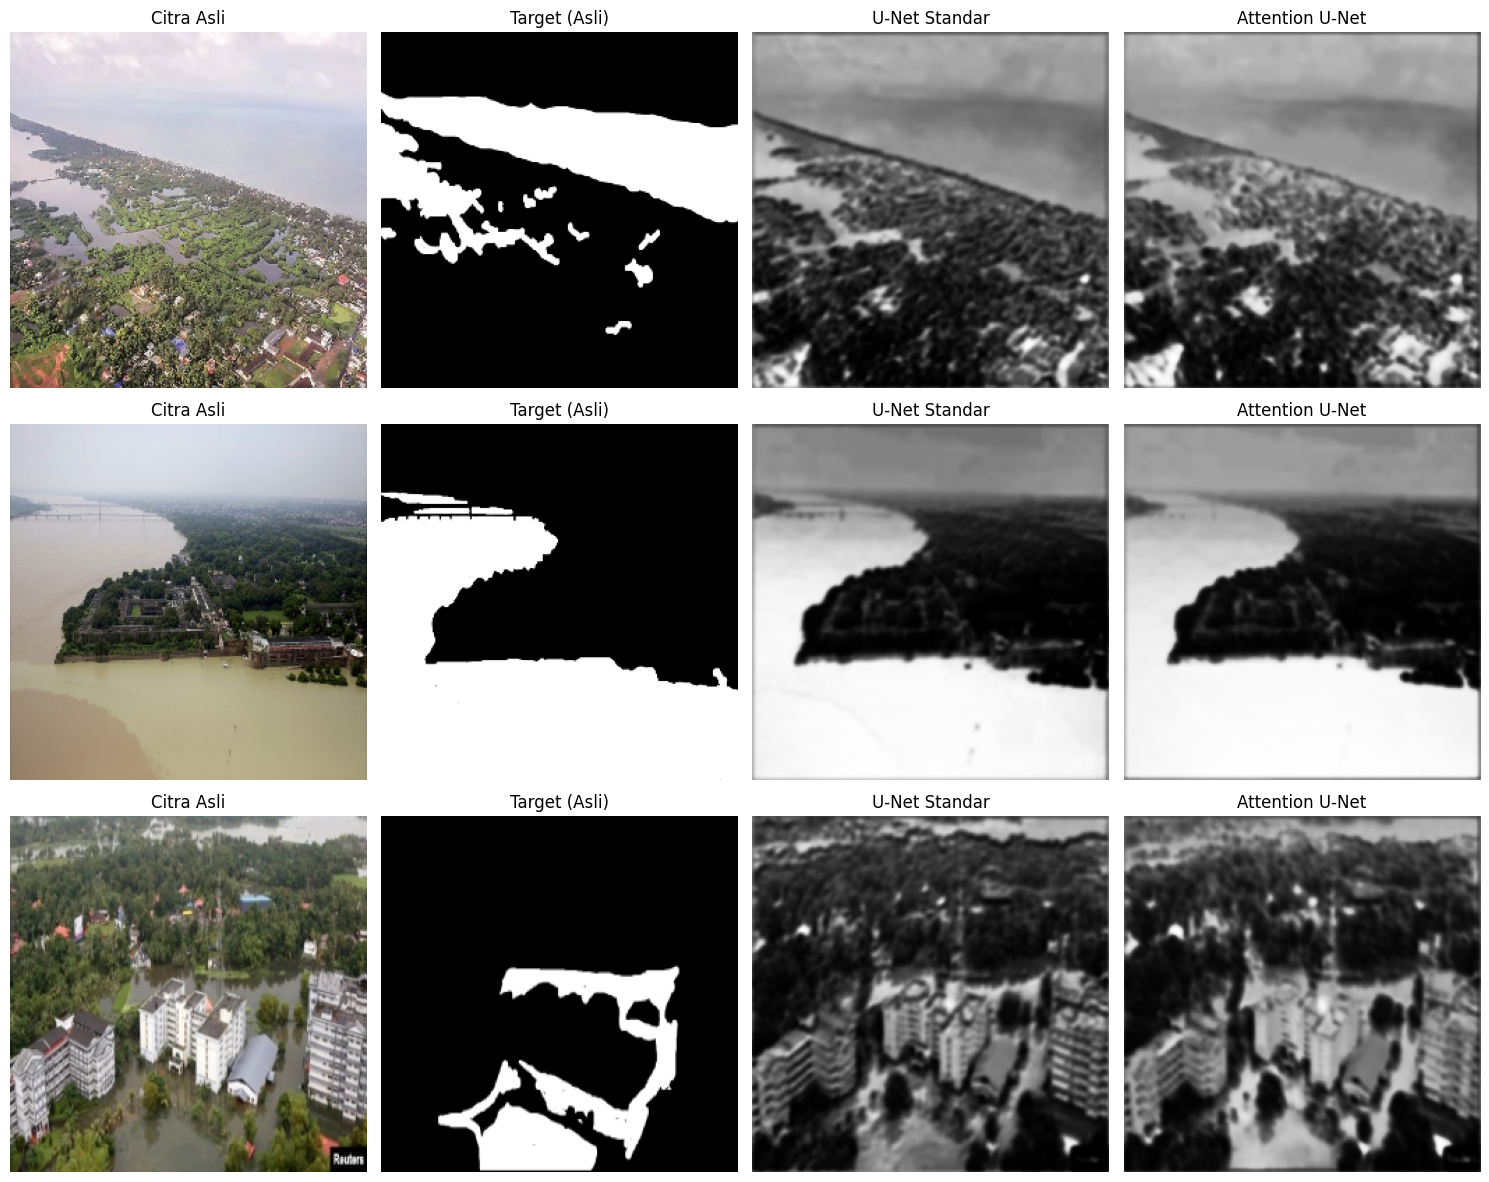

In [ ]:
def perbandingan_hasil(model1, model2, gen, jumlah=3):
    # Ambil satu batch data dari generator validasi
    x_test, y_test = gen[0]

    # Lakukan prediksi
    preds1 = model1.predict(x_test)
    preds2 = model2.predict(x_test)

    plt.figure(figsize=(15, jumlah * 4))
    for i in range(jumlah):
        # Citra Asli
        plt.subplot(jumlah, 4, i*4 + 1)
        plt.imshow(x_test[i])
        plt.title("Citra Asli")
        plt.axis('off')

        # Ground Truth (Mask asli)
        plt.subplot(jumlah, 4, i*4 + 2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title("Target (Asli)")
        plt.axis('off')

        # Prediksi U-Net Standar
        plt.subplot(jumlah, 4, i*4 + 3)
        plt.imshow(preds1[i].squeeze(), cmap='gray')
        plt.title("U-Net Standar")
        plt.axis('off')

        # Prediksi Attention U-Net
        plt.subplot(jumlah, 4, i*4 + 4)
        plt.imshow(preds2[i].squeeze(), cmap='gray')
        plt.title("Attention U-Net")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
perbandingan_hasil(model_std, model_att, val_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


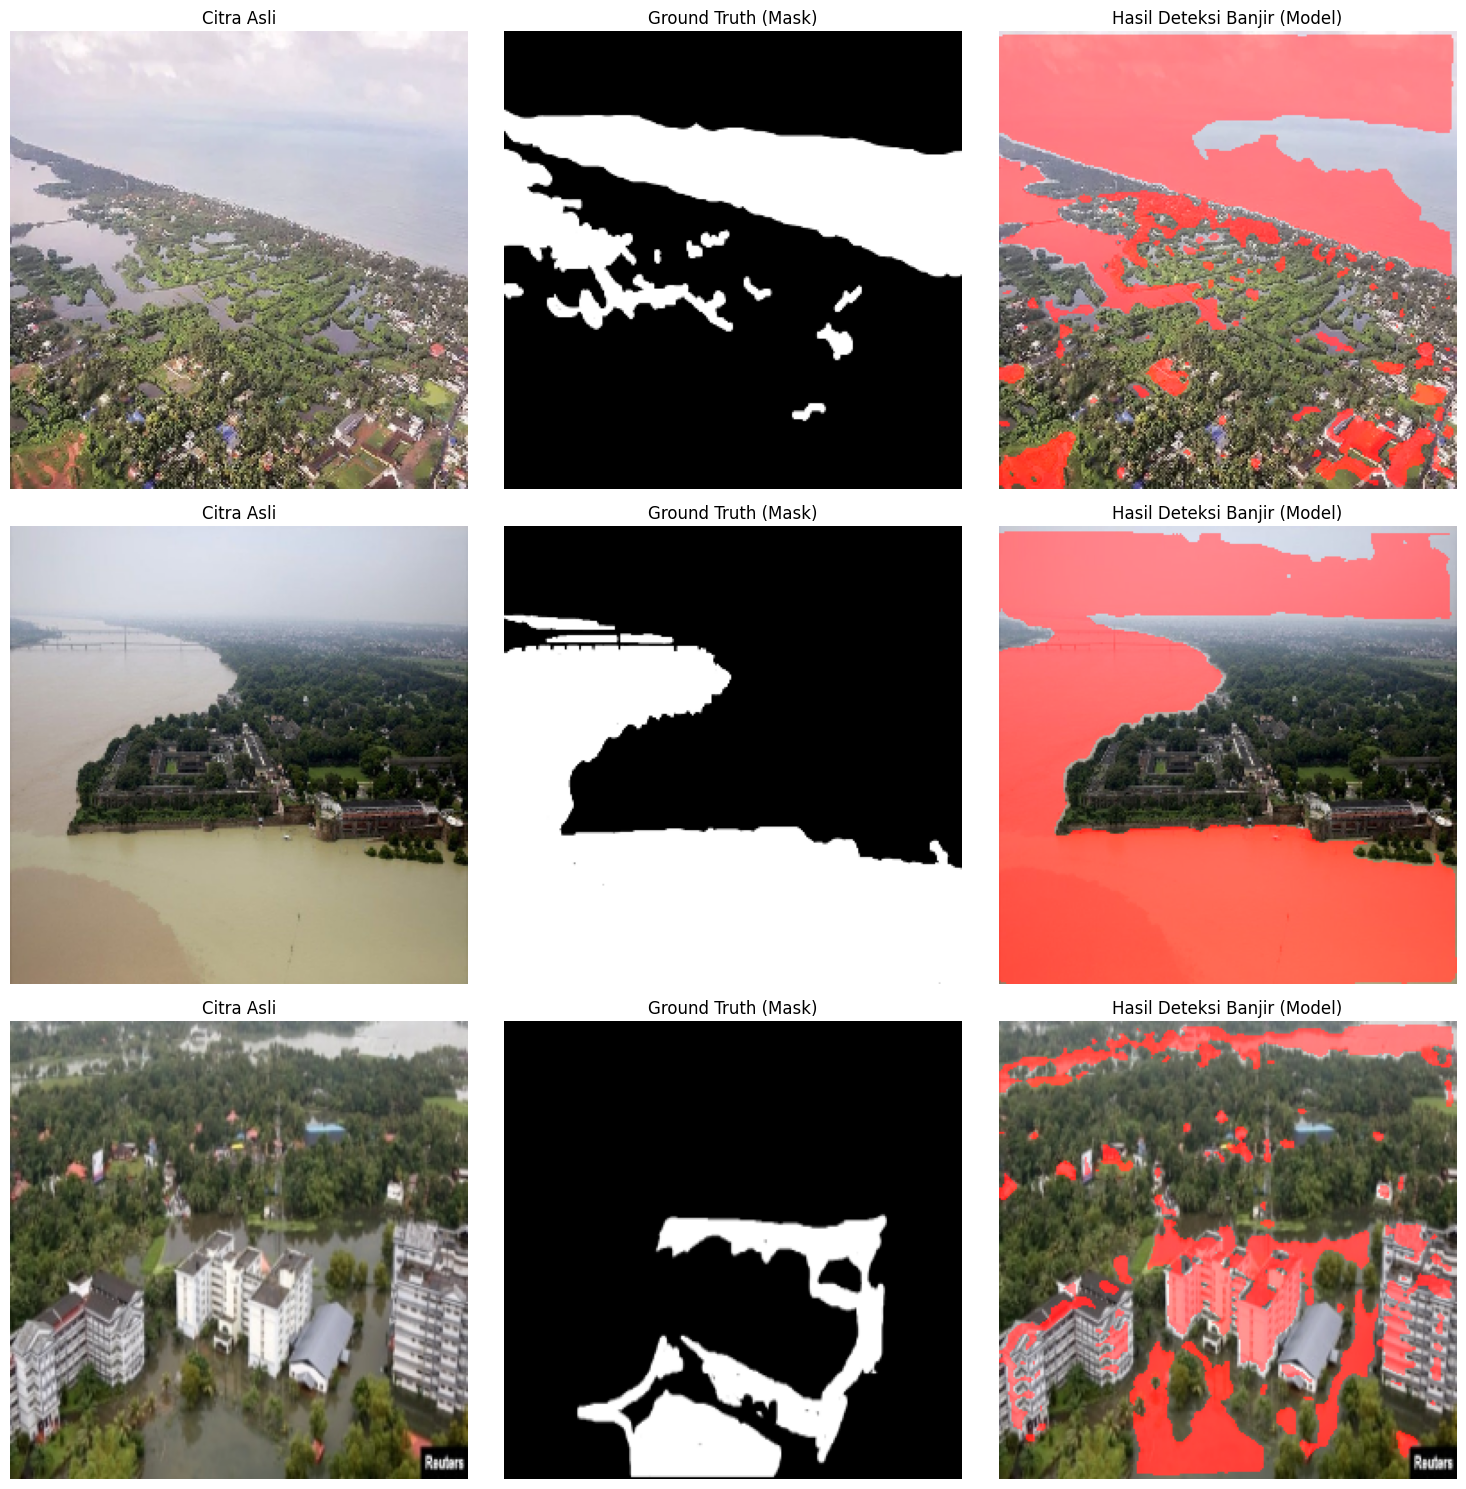

In [ ]:
def plot_overlay(img, mask, prediction, threshold=0.5):
    # Ubah prediksi menjadi binary mask berdasarkan threshold
    pred_bin = (prediction > threshold).astype(np.uint8)

    # Buat overlay warna merah untuk area prediksi banjir
    overlay = img.copy()
    red_mask = np.zeros_like(img)
    red_mask[:, :, 0] = 255 # Warna Merah

    # Terapkan warna merah pada area banjir yang diprediksi
    alpha = 0.4 # Transparansi
    mask_indices = pred_bin == 1
    overlay[mask_indices.squeeze()] = cv2.addWeighted(img[mask_indices.squeeze()], 1-alpha,
                                                       red_mask[mask_indices.squeeze()], alpha, 0)

    return overlay

def visualisasi_pro(model, gen, jumlah=3):
    x_test, y_test = gen[0]
    preds = model.predict(x_test)

    plt.figure(figsize=(15, jumlah * 5))
    for i in range(jumlah):
        # 1. Gambar Asli
        plt.subplot(jumlah, 3, i*3 + 1)
        plt.imshow(x_test[i])
        plt.title("Citra Asli")
        plt.axis('off')

        # 2. Ground Truth (Target Sebenarnya)
        plt.subplot(jumlah, 3, i*3 + 2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title("Ground Truth (Mask)")
        plt.axis('off')

        # 3. Hasil Deteksi (Overlay Merah)
        plt.subplot(jumlah, 3, i*3 + 3)
        res_overlay = plot_overlay(x_test[i], y_test[i], preds[i])
        plt.imshow(res_overlay)
        plt.title("Hasil Deteksi Banjir (Model)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan hasil Attention U-Net dengan Overlay
visualisasi_pro(model_att, val_gen)

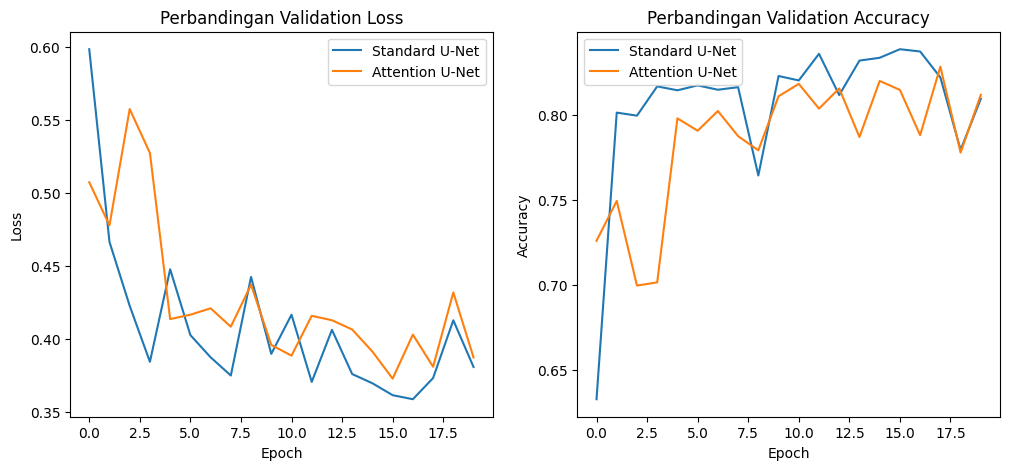

In [ ]:
def plot_history(hist_std, hist_att):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist_std.history['val_loss'], label='Standard U-Net')
    plt.plot(hist_att.history['val_loss'], label='Attention U-Net')
    plt.title('Perbandingan Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist_std.history['val_accuracy'], label='Standard U-Net')
    plt.plot(hist_att.history['val_accuracy'], label='Attention U-Net')
    plt.title('Perbandingan Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history_std, history_att)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


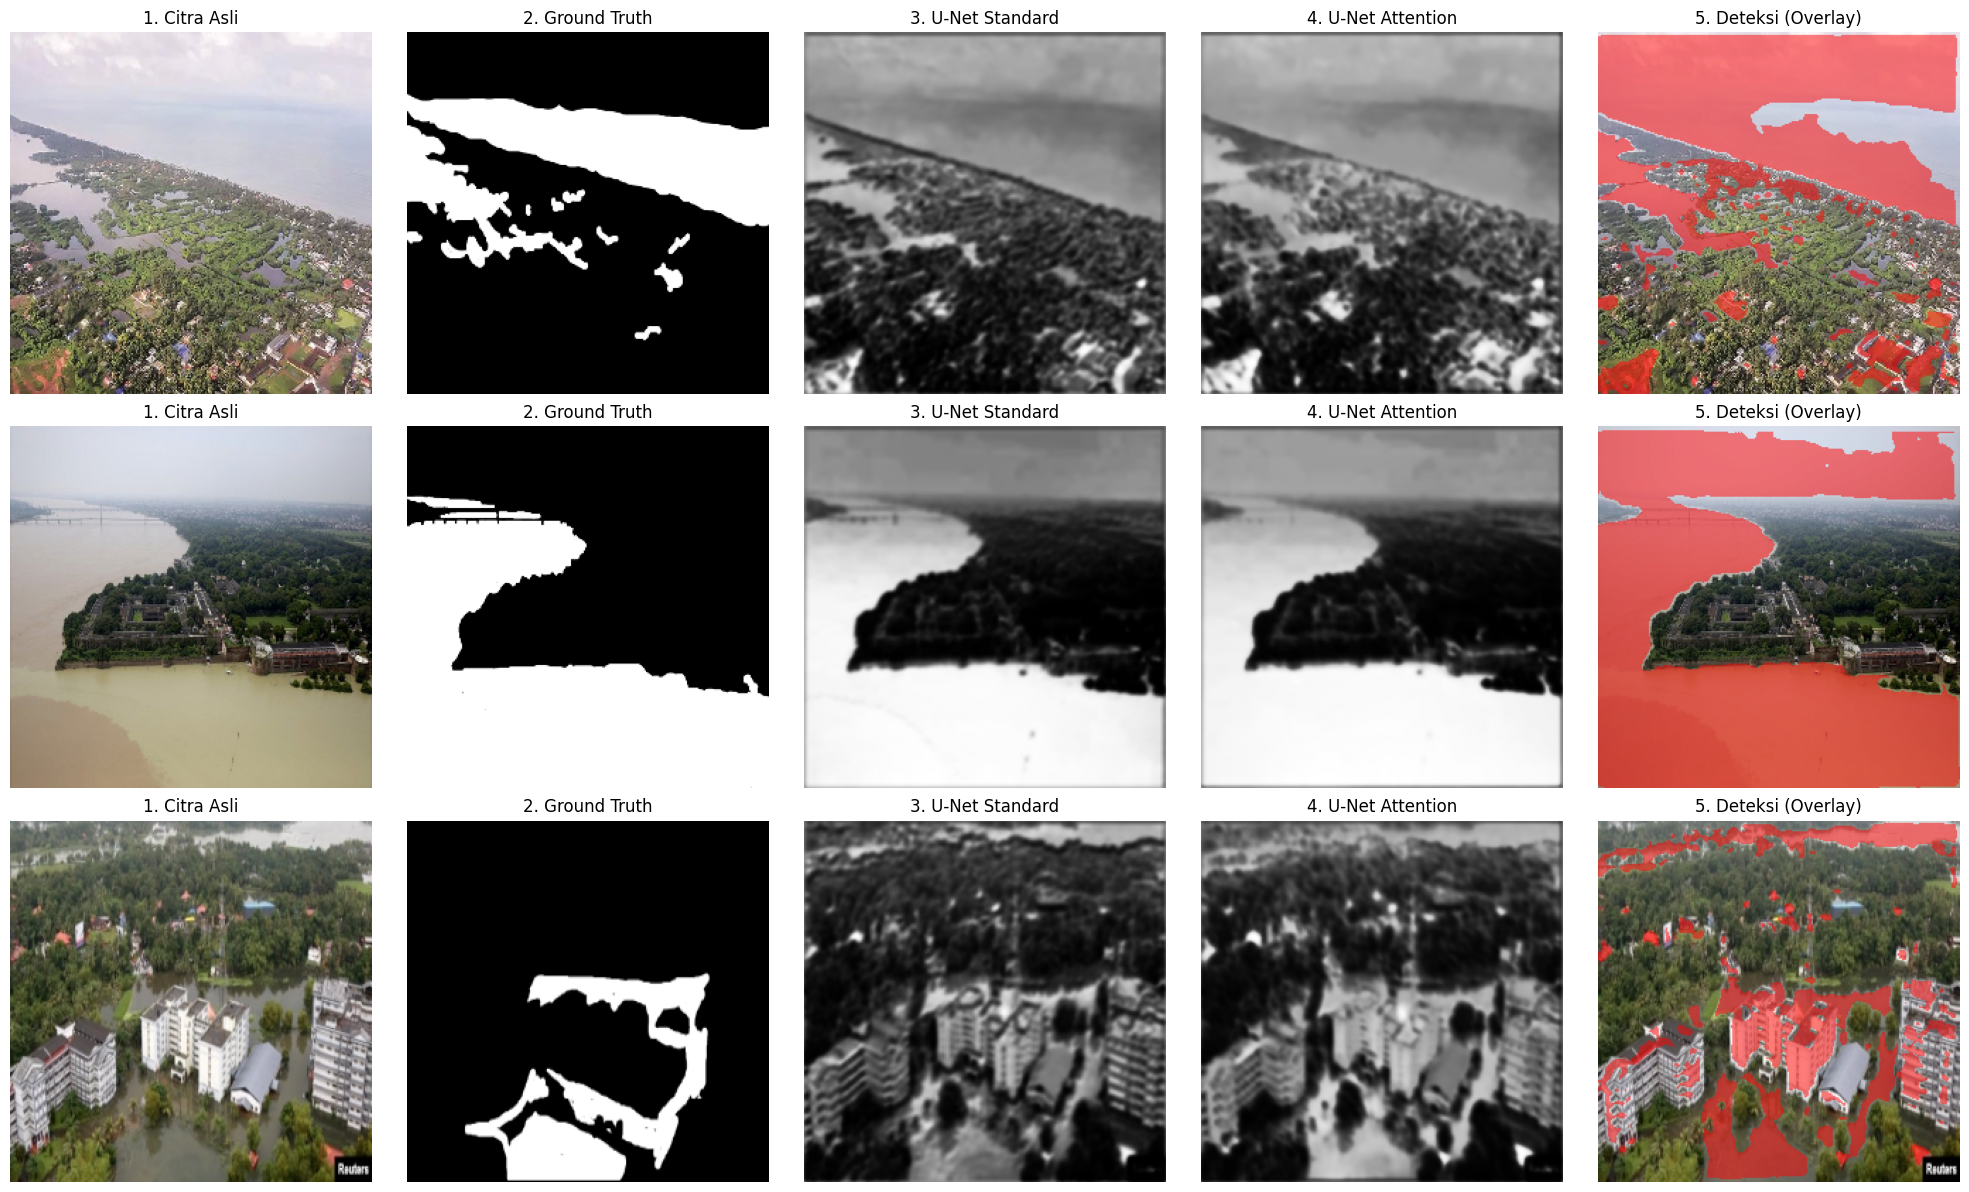

In [ ]:
def visualisasi_final_komprehensif(model_std, model_att, gen, jumlah=3, threshold=0.5):
    # Ambil data dari generator
    x_test, y_test = gen[0]

    # Prediksi dari kedua model
    preds_std = model_std.predict(x_test)
    preds_att = model_att.predict(x_test)

    plt.figure(figsize=(20, jumlah * 4))

    for i in range(jumlah):
        # 1. Citra Asli
        plt.subplot(jumlah, 5, i*5 + 1)
        plt.imshow(x_test[i])
        plt.title("1. Citra Asli")
        plt.axis('off')

        # 2. Ground Truth (Mask asli dari Drive)
        plt.subplot(jumlah, 5, i*5 + 2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title("2. Ground Truth")
        plt.axis('off')

        # 3. Prediksi U-Net Standard (Hitam Putih)
        plt.subplot(jumlah, 5, i*5 + 3)
        plt.imshow(preds_std[i].squeeze(), cmap='gray')
        plt.title("3. U-Net Standard")
        plt.axis('off')

        # 4. Prediksi U-Net Attention (Hitam Putih)
        plt.subplot(jumlah, 5, i*5 + 4)
        plt.imshow(preds_att[i].squeeze(), cmap='gray')
        plt.title("4. U-Net Attention")
        plt.axis('off')

        # 5. Hasil Deteksi Akhir (Overlay Merah pada Citra Asli)
        # Kita gunakan hasil dari Attention U-Net karena akurasinya lebih baik
        plt.subplot(jumlah, 5, i*5 + 5)

        # Proses Overlay
        img_original = (x_test[i] * 255).astype(np.uint8)
        pred_mask = (preds_att[i].squeeze() > threshold).astype(np.uint8)

        overlay = img_original.copy()
        # Membuat warna merah (RGB: 255, 0, 0)
        red_color = np.array([255, 0, 0], dtype='uint8')

        # Menimpa area banjir dengan warna merah
        overlay[pred_mask == 1] = cv2.addWeighted(overlay[pred_mask == 1], 0.5,
                                                 np.full_like(overlay[pred_mask == 1], red_color), 0.5, 0)

        plt.imshow(overlay)
        plt.title("5. Deteksi (Overlay)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan hasil visualisasi 5 kolom
visualisasi_final_komprehensif(model_std, model_att, val_gen, jumlah=3)